In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [20]:
# Manually read and parse the file line by line to extract the structured data

def dataSize_packetLatency(file_path):
    data_list = []
    
    with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.split()
            if len(parts) == 7:
                data_list.append([int(parts[0]), int(parts[1]), int(parts[2]), float(parts[3]),
                                  int(parts[4]), float(parts[5]), float(parts[6])])
    
    # Create DataFrame and filter out rows with zero Total_Data_Size
    data_df = pd.DataFrame(data_list, columns=["LP_id", "Terminal_ID", "Total_Data_Size", 
                                               "Aggregate_Packet_Latency", "Num_Flits_Packets_Finished", 
                                               "Avg_Hops", "Busy_Time"])
    data_filtered_df = data_df[data_df["Total_Data_Size"] > 0].copy()
    
    # Clustering based on Total Data Size only
    X = data_filtered_df[["Total_Data_Size"]].values
    
    # Using 4 clusters based on Total Data Size
    kmeans = KMeans(n_clusters=3, random_state=42)
    data_filtered_df.loc[:, "Cluster"] = kmeans.fit_predict(X)
    
    # Determine the min and max Total Data Size for each cluster to label intervals
    cluster_ranges = data_filtered_df.groupby("Cluster")["Total_Data_Size"].agg(["min", "max"]).reset_index()
    cluster_ranges["Interval"] = cluster_ranges.apply(lambda row: f"{int(row['min'])}-{int(row['max'])}", axis=1)
    
    # Map cluster labels to intervals
    interval_map = dict(zip(cluster_ranges["Cluster"], cluster_ranges["Interval"]))
    data_filtered_df.loc[:, "Cluster_Interval"] = data_filtered_df["Cluster"].map(interval_map)
    
    # Create a violin plot for aggregate packet latency grouped by cluster intervals
    plt.figure(figsize=(6, 6))
    sns.violinplot(x="Cluster_Interval", y="Aggregate_Packet_Latency", data=data_filtered_df)
    # plt.title("Violin Plot of Aggregate Packet Latency by Total Data Size Intervals")
    plt.xlabel("Total Data Size Interval")
    plt.ylabel("Aggregate Packet Latency")
    plt.xticks()
    plt.grid(axis='y')
    plt.show()

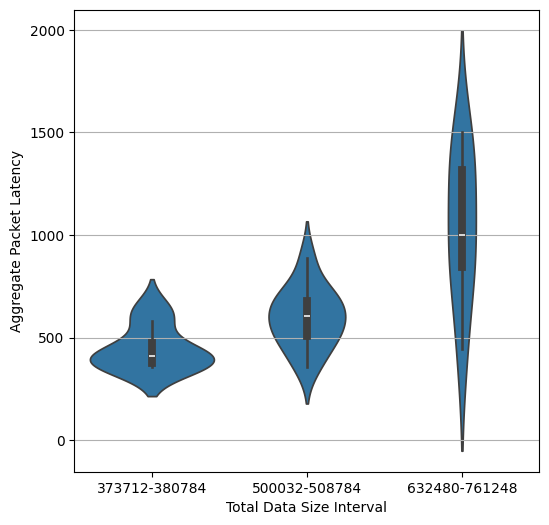

In [21]:
dataSize_packetLatency("./amg_27_dfly/dragonfly-msg-stats")